In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import yfinance as yf
import pandas as pd
import numpy as np

import utils as lbl_utils
import ct_two_state as ct2
import ct_three_state as ct3
import fixed_time_horizon as fth
import oracle
import triple_barrier as tb

In [2]:
ticker_symbol = 'GC=F'
start_date = '2023-10-20'
end_date = '2023-10-21'
start_time = "09:00:00" #"10:50:00"
end_time = "14:00:00" #"12:00:00"

prices = yf.download(ticker_symbol, start_date, end_date, interval='1m')['Close'].between_time(start_time, end_time)
prices.index = prices.index.tz_localize(None)

print(prices.shape)
print(prices.head())

[*********************100%%**********************]  1 of 1 completed
(301,)
Datetime
2023-10-20 09:00:00    1991.199951
2023-10-20 09:01:00    1990.800049
2023-10-20 09:02:00    1990.000000
2023-10-20 09:03:00    1989.500000
2023-10-20 09:04:00    1989.500000
Name: Close, dtype: float64


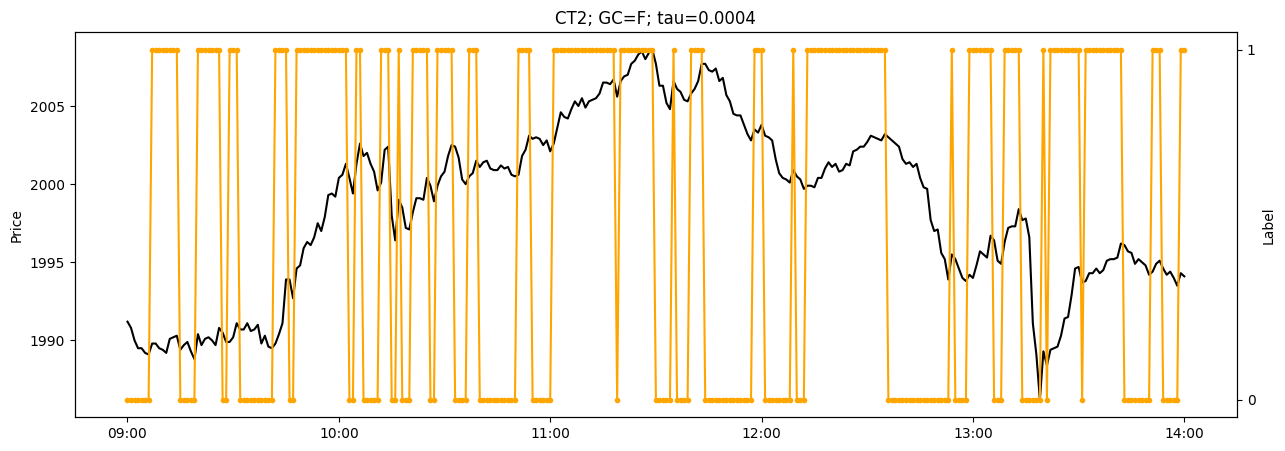

comulative return: 1.3912430868395775%


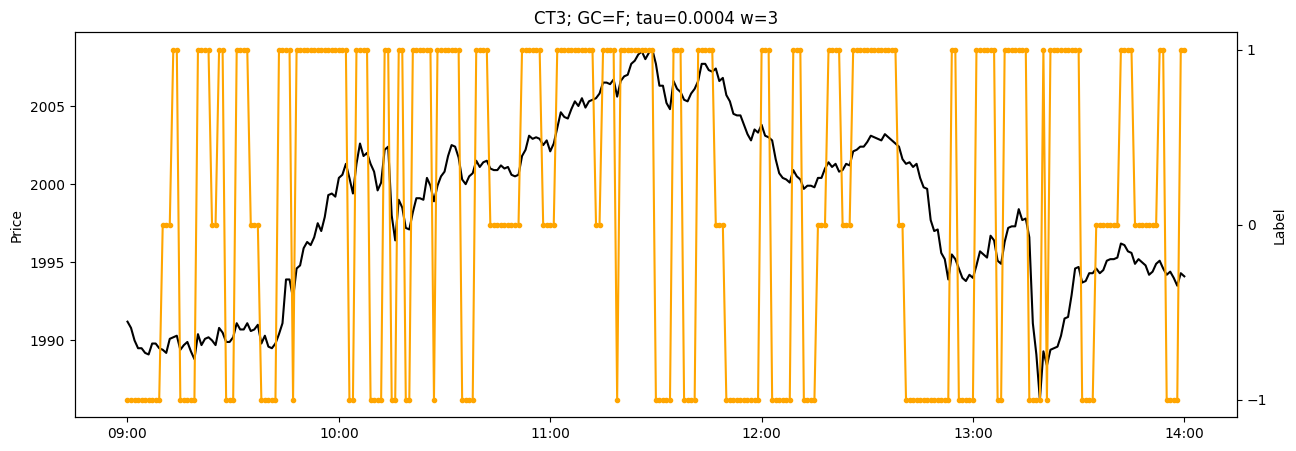

comulative return: 0.0011878286182653852%


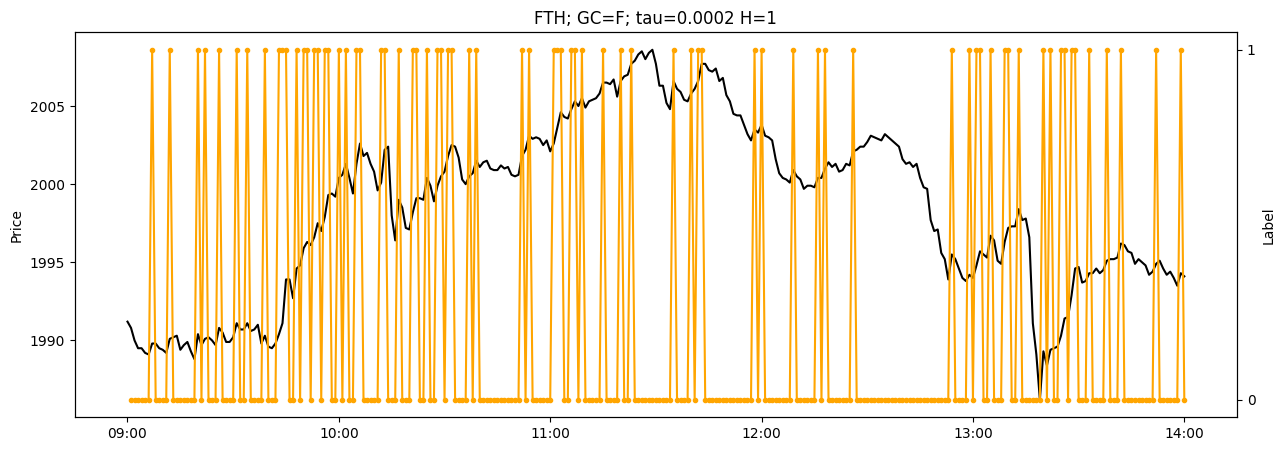

comulative return: -1.2318448994490194%


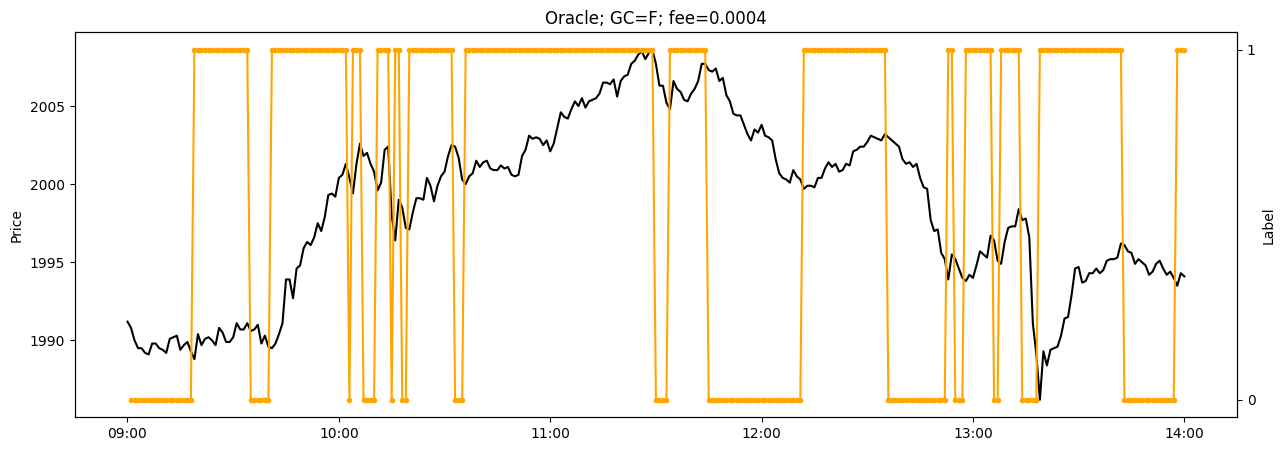

comulative return: 2.5607358475951525%


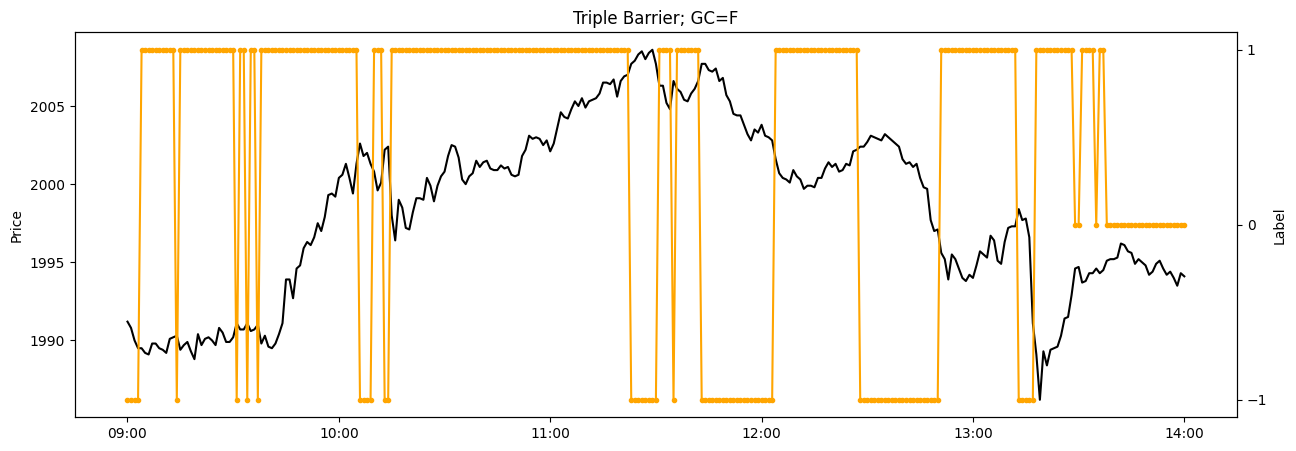

comulative return: 0.810517425419266%


In [7]:
trans_fee = 0.0004
#-------------------------------------------
tau = 0.0004
labels = ct2.binary_trend_labels(prices, tau=tau)
lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tau = 0.0004
window = 3
labels = ct3.get_labels(prices, tau=tau, w=window)
lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tau = 0.0002
H = 1
labels = fth.binary_trend_labels(prices, tau=tau, H=H)
lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
fee = 0.0004
labels = oracle.binary_trend_labels(prices, fee=fee)
lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
labels = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1)
lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
# Meta labeling
#side = labels
#side[side == 0] = -1
#side = side.shift(1).fillna(method='bfill')
#labels_2 = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1, side=side)
# iterate through labels_2 and if it has value 1 set ti to value from labels on same index, otherwise set to 0
#labels_2 = pd.Series((labels[i] if labels_2[i] == 1 else 0 for i in labels_2.index), index=labels_2.index)
#lbl_utils.plot_labels('TB Meta Labeling; {}'.format(ticker_symbol), prices, labels_2)


In [4]:
fee = 0.0004
num_threads = 6
#-------------------------------------------
# CT2
"""
print('Optimizing CT2')
param_grid = [
    np.arange(0, 0.003, 0.00002).tolist() # tau
]
best_params = lbl_utils.optimize_label_params(binary_trend_labels=ct2.binary_trend_labels, prices=prices
                                        , param_grid=param_grid, fee=fee, num_threads=num_threads)
with open('./best_params.txt', 'a') as f:
    f.write('CT2; fee={}; tau={}\n'.format(fee, best_params[0]))
# CT3
print('Optimizing CT3')
param_grid = [
    np.arange(0, 0.003, 0.00002).tolist(),  # tau
    np.arange(0, 20, 1).tolist()            # window
]
best_params = lbl_utils.optimize_label_params(binary_trend_labels=ct3.binary_trend_labels, prices=prices, 
                                              param_grid=param_grid, fee=fee, num_threads=num_threads)
with open('./best_params.txt', 'a') as f:
    f.write('CT3; fee={}; tau={}; window={}\n'.format(fee, best_params[0], best_params[1]))

# FTH
print('Optimizing FTH')
param_grid = [
    np.arange(0, 0.0003, 0.000001).tolist(),  # tau
    np.arange(1, 20, 1).tolist()            # H
]
best_params = lbl_utils.optimize_label_params(binary_trend_labels=fth.binary_trend_labels, prices=prices,
                                              param_grid=param_grid, fee=fee, num_threads=num_threads)
with open('./best_params.txt', 'a') as f:
    f.write('FTH; fee={}; tau={}; H={}\n'.format(fee, best_params[0], best_params[1]))
"""
# Triple Barrier
print('Optimizing Triple Barrier')
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
param_grid = [
    [tEvents],                          # tEvents
    np.arange(0, 4.2, 0.1).tolist(),  #pt
    np.arange(0, 4.2, 0.1).tolist(),  #sl
    [minuteVol],                        # volatility
    [0],                                # minRet
    [t1],                               # t1
]
best_params = lbl_utils.optimize_label_params(binary_trend_labels=tb.binary_trend_labels, prices=prices,
                                              param_grid=param_grid, fee=fee, num_threads=num_threads)
with open('./best_params.txt', 'a') as f:
    f.write('TB; fee={}; pt={}; sl={}\n'.format(fee, best_params[1], best_params[2]))

Optimizing Triple Barrier
Number of parameter combinations: 1764
Number of threads: 6, Number of parameter combinations per thread: 294


Optimizing: 100%|███████████████████████████████████████████████| 1764/1764 [08:41<00:00,  3.38it/s]


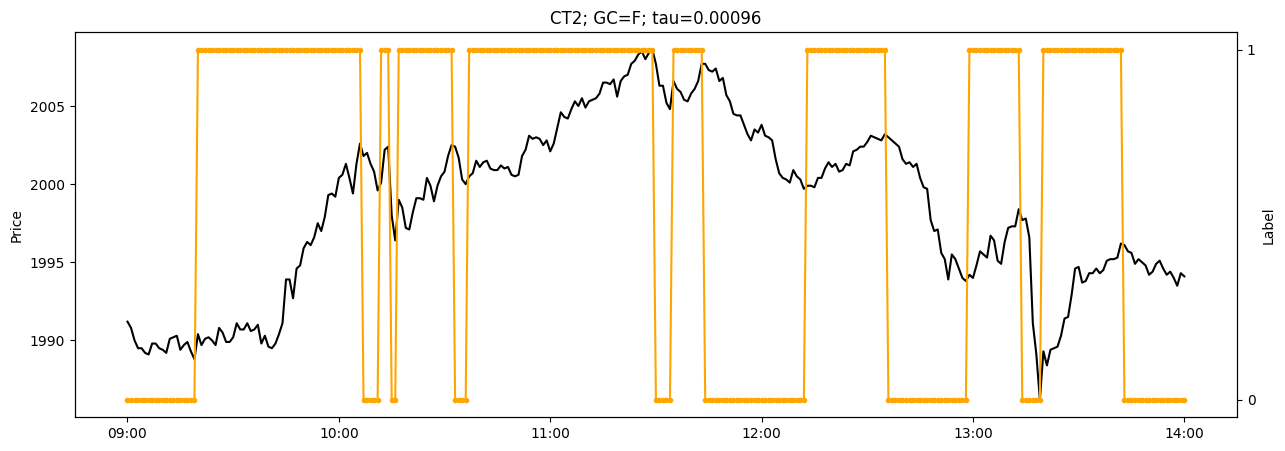

comulative return: 1.7768667132342486%


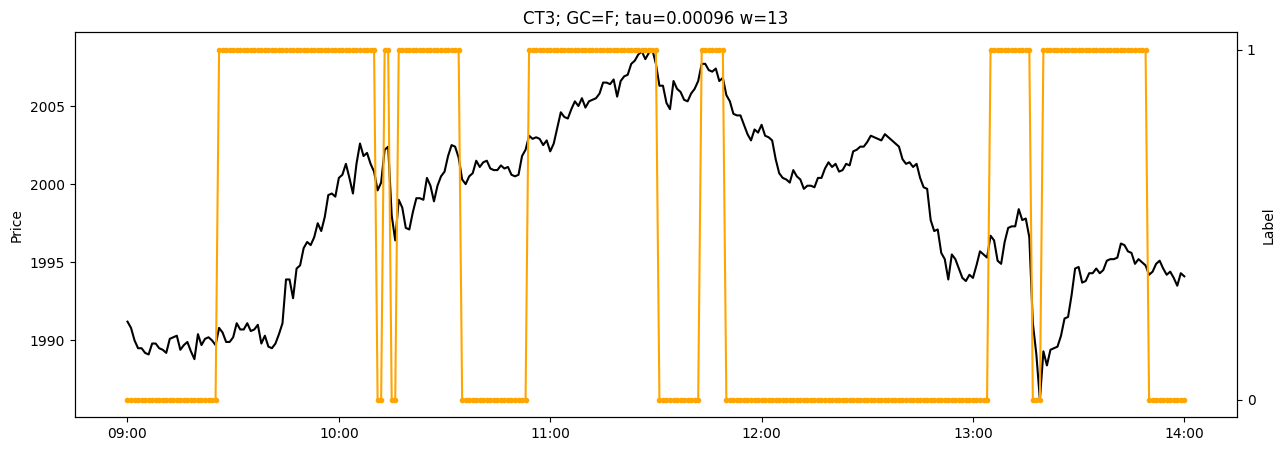

comulative return: 0.8249852135635116%


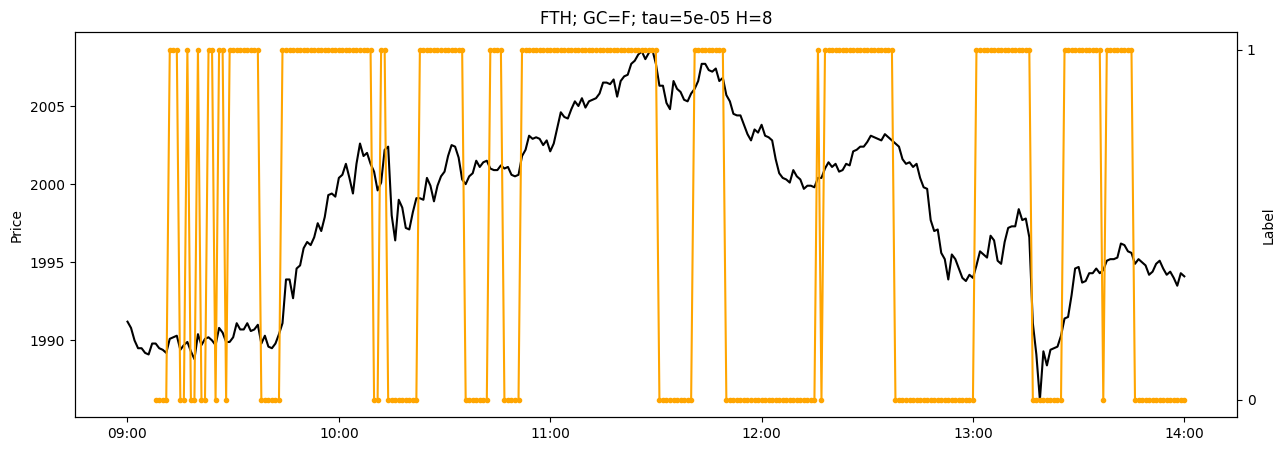

comulative return: 0.7284933788022085%


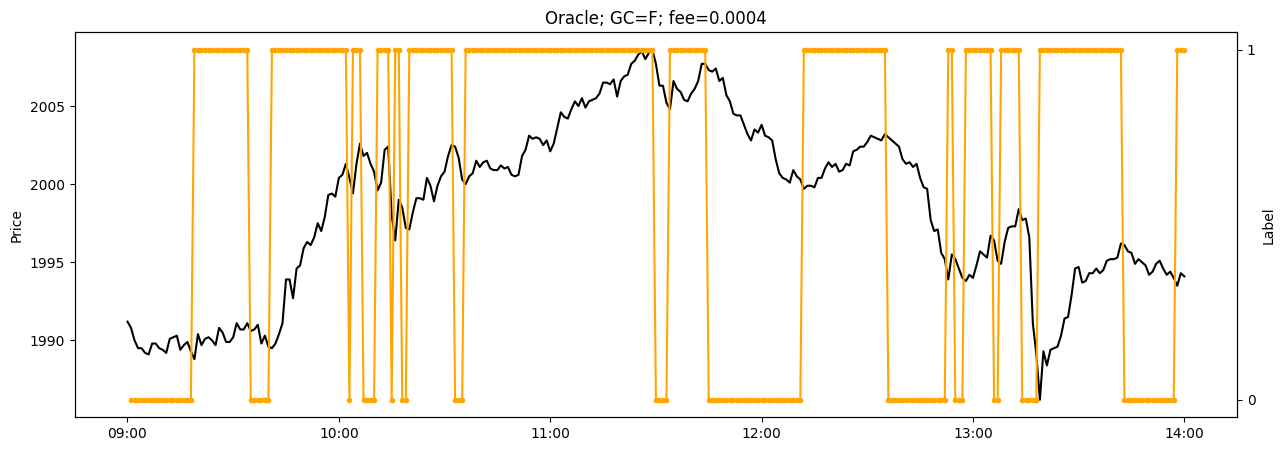

comulative return: 2.5607358475951525%


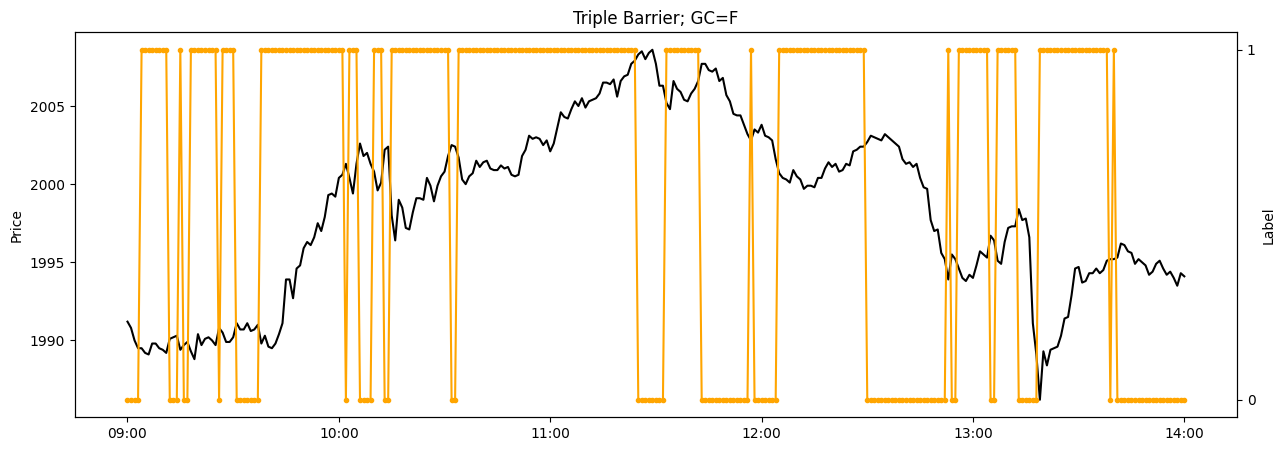

comulative return: 1.1136494942640462%


In [9]:
trans_fee = 0.0004
#-------------------------------------------
tau = 0.00096
labels = ct2.binary_trend_labels(prices, tau=tau)
lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tau = 0.00096
window = 13
labels = ct3.binary_trend_labels(prices, tau=tau, w=window)
lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tau = 0.00005
H = 8
labels = fth.binary_trend_labels(prices, tau=tau, H=H)
lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
fee = 0.0004
labels = oracle.binary_trend_labels(prices, fee=fee)
lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
labels = tb.binary_trend_labels(prices, tEvents, pt=0.6, sl=1.3, volatility=minuteVol, minRet=0, t1=t1)
lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))